# Dependency parsing

In [ ]:
# Load data with identity term matches extracted, tokenized
import pandas as pd

path = '../../data/incels/processed_comments.pkl'
# path = '../data/white_supremacist_identities.pkl'
data = pd.read_pickle(path)
data.info()

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['ner'])

In [ ]:
samp = data[data.netmapper_identity_matches.map(lambda x: len(x) > 0)].head(1)
samp

In [ ]:
pd.set_option('display.max_colwidth', None)
test = test.loc[12, 'content']

In [ ]:
doc = nlp(test)
doc

In [ ]:
parse = [tok.dep_ for tok in doc]
parse

In [ ]:
parse[tok_idx]

In [ ]:
[tok.head for tok in doc][tok_idx]

In [ ]:
# Match extracted identities to tokens
from collections import defaultdict

actions_attributes = {} # identity: {'actions': [actions], {'attributes': [attributes]} # replace with separate columns of attributes and actions in exploded df
identity_ctr = defaultdict(int) # keep track of how many of this identity I've seen

for identity in samp.loc[12, 'netmapper_identity_matches']:
    
    # Get identity mention locations
    mention_idx = [i for i, tok in enumerate(doc) if tok.text==identity]
    tok_idx = mention_idx[identity_ctr[identity]]
    
    # Verbs where identity term was the subject
    verbs_subj = [tok.head.text for tok in doc if tok.i==tok_idx \
        in mention_idx and (tok.dep_=='nsubj' or tok.dep_=='agent')]

    # Verbs where identity term was the object
    verbs_obj = [tok.head.text for tok in doc if tok.i==tok_idx and \
        (tok.dep_=='dobj' or tok.dep_=='nsubjpass' or \
        tok.dep_=='dative' or tok.dep_=='pobj')]

    # Adjectives that describe the identity term
    adjs = [tok.text.lower() for tok in doc if tok.head.i == tok_idx and \
        (tok.dep_=='amod' or tok.dep_=='appos' or \
        tok.dep_=='nsubj' or tok.dep_=='nmod')] \
        + [tok.text.lower() for tok in doc if tok.dep_=='attr' and \
            (tok.head.text=='is' or tok.head.text=='was') and \
           any([c.i==tok_idx for c in tok.head.children])]
    
    actions_attributes[identity] = {'actions': verbs_subj + verbs_obj, 'attributes': adjs}
    identity_ctr[identity] += 1
    
actions_attributes

In [ ]:
# Create a list of identity term unique indexes for each identity term list
data['netmapper_identity_matches']

In [ ]:
from collections import defaultdict, Counter

def unique_term_index(l):
    ctr = Counter()
    res = []
    for term in l:
        res.append(ctr[term])
        ctr[term] += 1
    return res

In [ ]:
unique_term_index(['incels', 'incels', 'teen'])

# Aggregate extracted actions and attributes

In [5]:
# Load data with extracted actions and attributes
import pandas as pd

path = '../../data/incels/processed_comments.pkl'
data = pd.read_pickle(path)
data.info()

exp = data.explode(['netmapper_identity_matches', 'actions_attributes'])
# exp.info()

# Group identities
import json

identity_groups_fpath = '../resources/identity_groups.json'
with open(identity_groups_fpath, 'r') as f:
    identity_groups = json.load(f)
print(len(identity_groups))

exp['identity_group'] = exp.netmapper_identity_matches.map(lambda x: identity_groups.get(x, x))
exploded = exp.explode('identity_group') # Count intersectional mentions as a mention in each of their categories
exploded.info()

# %%timeit -n 1 -r 1 # make Counter right away
from collections import Counter

# samp = exploded.sample(int(1e6))
# gped = samp.groupby('identity_group')
gped = exploded.groupby('identity_group')

# Aggregate actions and attribute for different identities
# agg = gped.agg({'actions_attributes': lambda x: {'actions': Counter([action for el in x for action in el['actions']]).most_common(),
#                                                 'attributes': Counter([attr for el in x for attr in el['attributes']]).most_common()},
#                                                'content': 'count'
#                                               })
agg = gped.agg(verbs_subj = pd.NamedAgg(column='actions_attributes', aggfunc=lambda x: Counter([term for el in x for term in el['verbs_subj']]).most_common()),
                verbs_obj = pd.NamedAgg(column='actions_attributes', aggfunc=lambda x: Counter([term for el in x for term in el['verbs_obj']]).most_common()),
                adjs = pd.NamedAgg(column='actions_attributes', aggfunc=lambda x: Counter([term for el in x for term in el['adjs']]).most_common()),
                count = pd.NamedAgg(column='content', aggfunc='count'))
agg.sort_values('count', ascending=False, inplace=True)
agg.info()
# agg[['verbs_subj', 'verbs_obj', 'adjs']].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6248230 entries, 0 to 6248229
Data columns (total 11 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   type                              object        
 1   forum                             object        
 2   thread                            object        
 3   username                          object        
 4   date                              object        
 5   content                           object        
 6   parsed_date                       datetime64[ns]
 7   content_orig                      object        
 8   netmapper_identity_matches        object        
 9   netmapper_identity_matches_spans  object        
 10  actions_attributes                object        
dtypes: datetime64[ns](1), object(10)
memory usage: 524.4+ MB
513
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13578886 entries, 0 to 6248229
Data columns (total 12 columns):
 #   

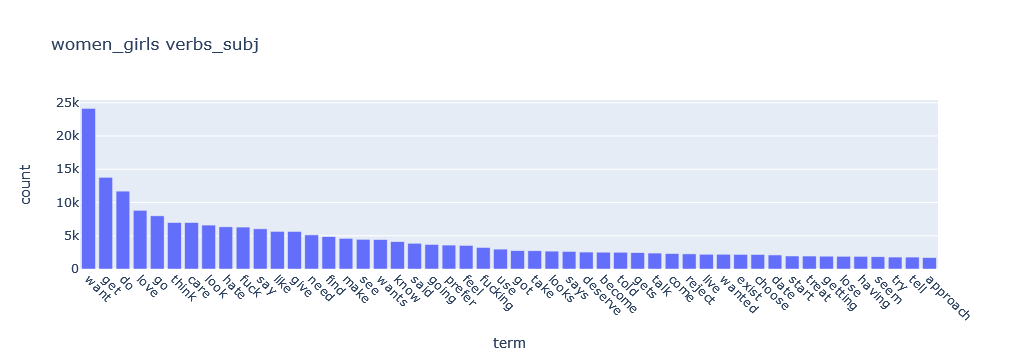

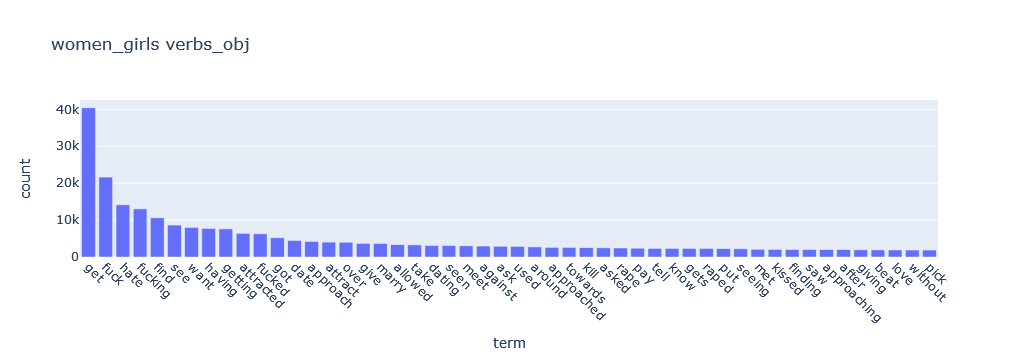

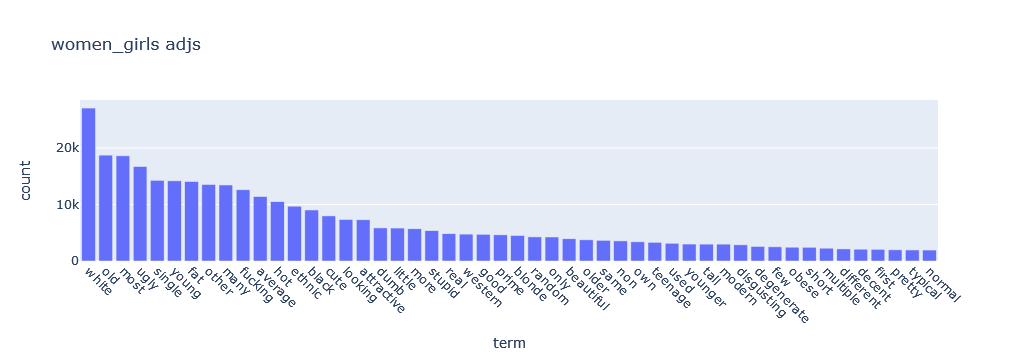

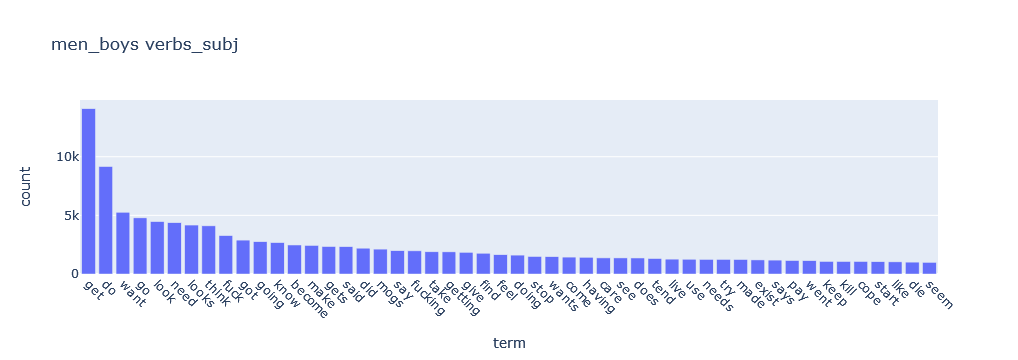

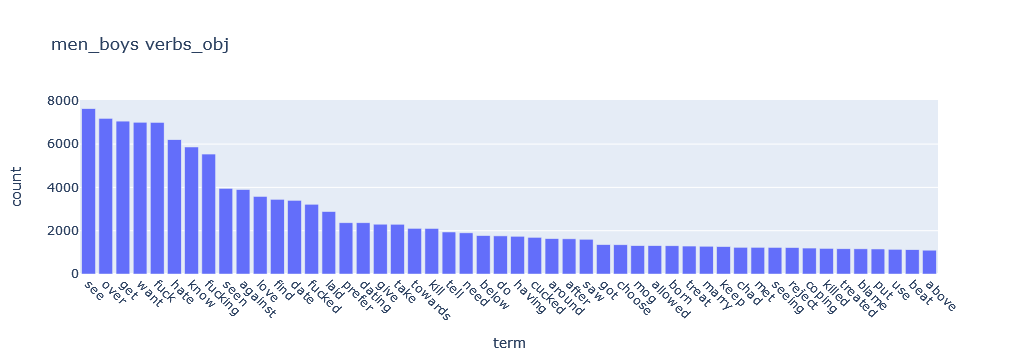

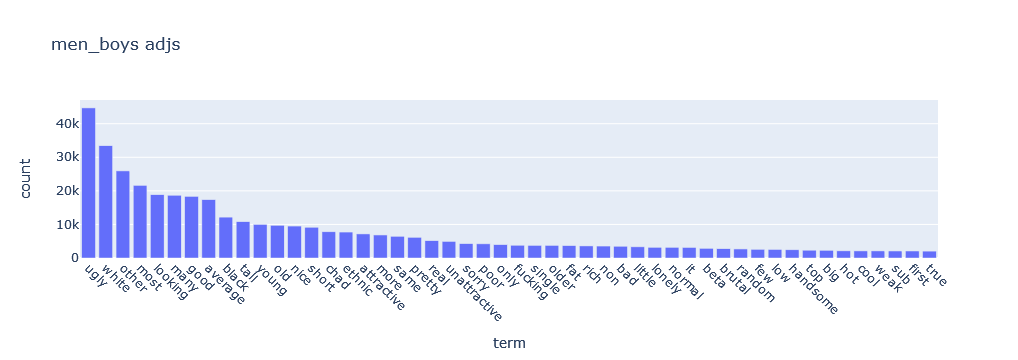

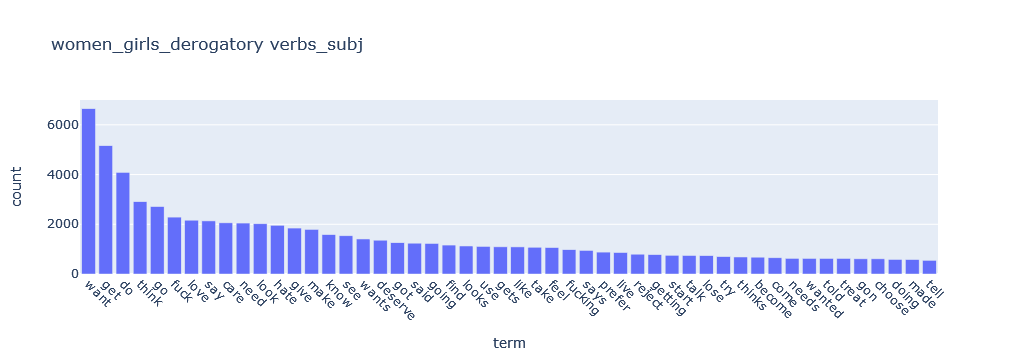

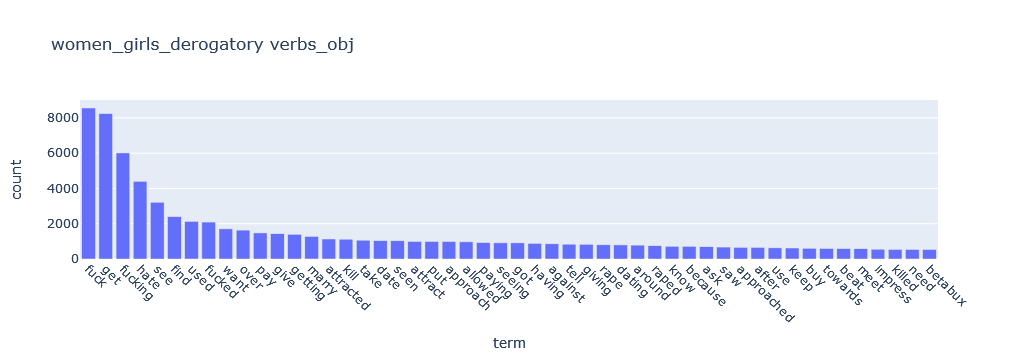

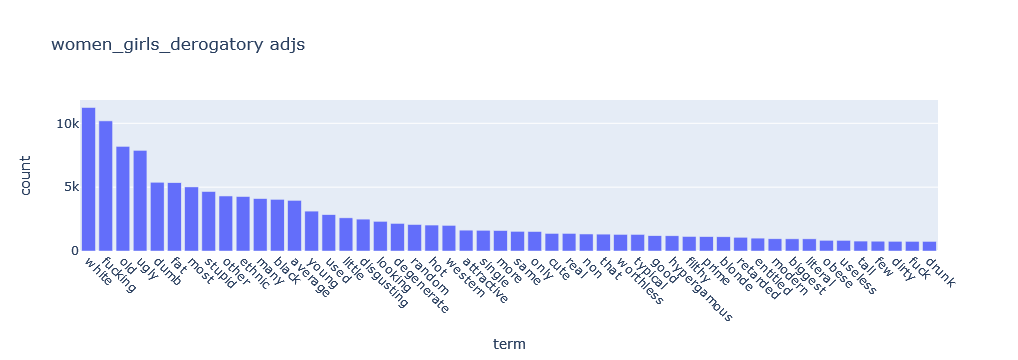

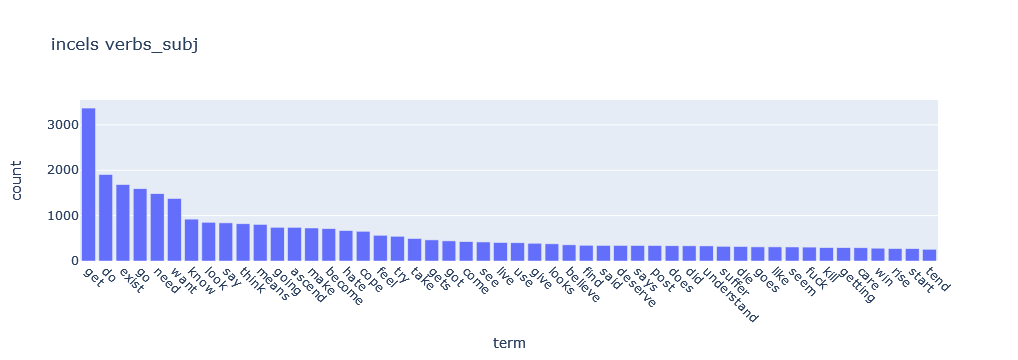

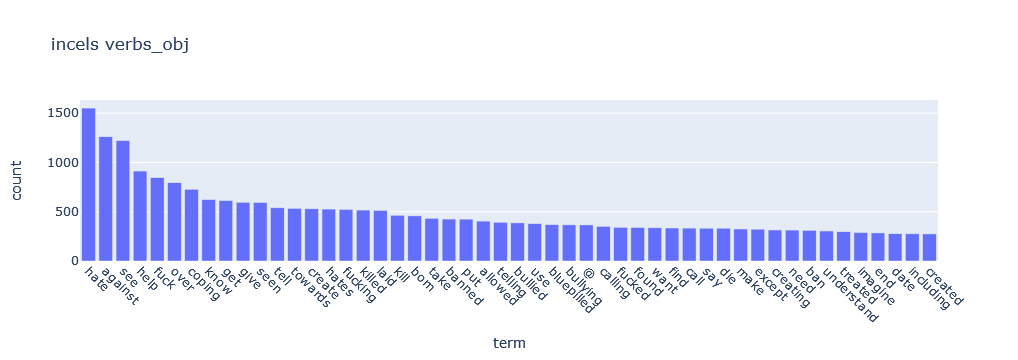

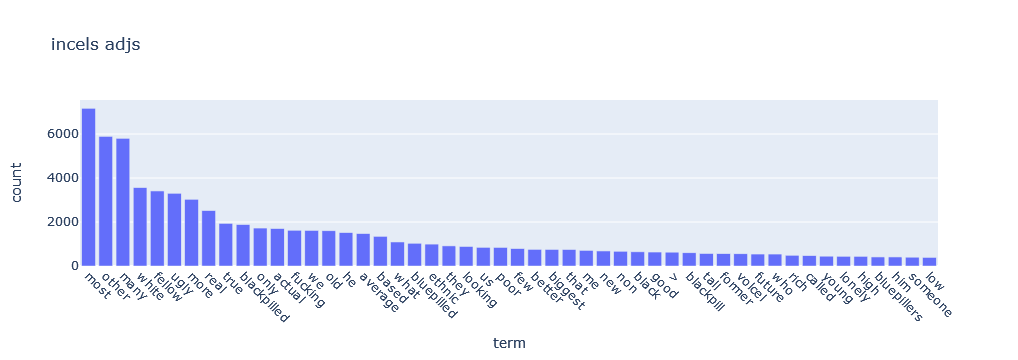

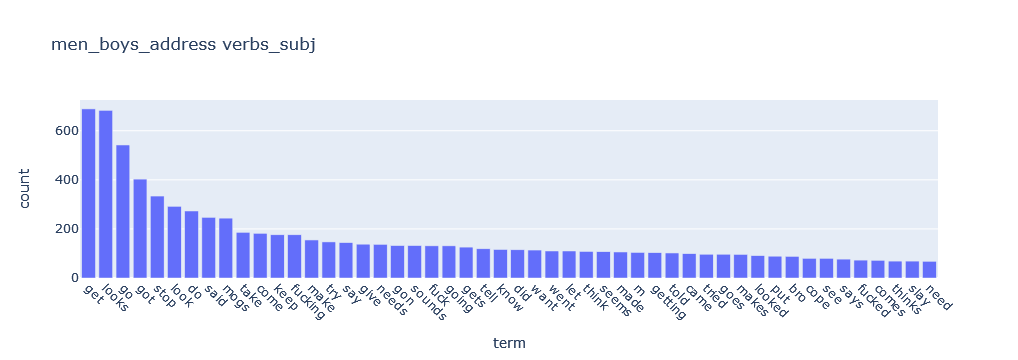

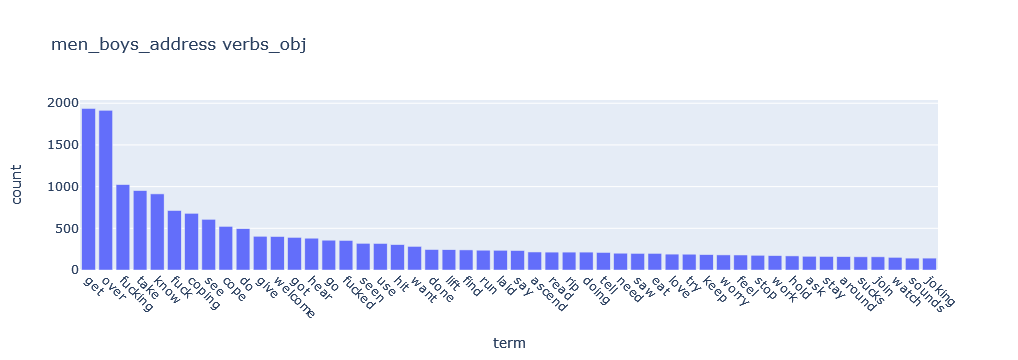

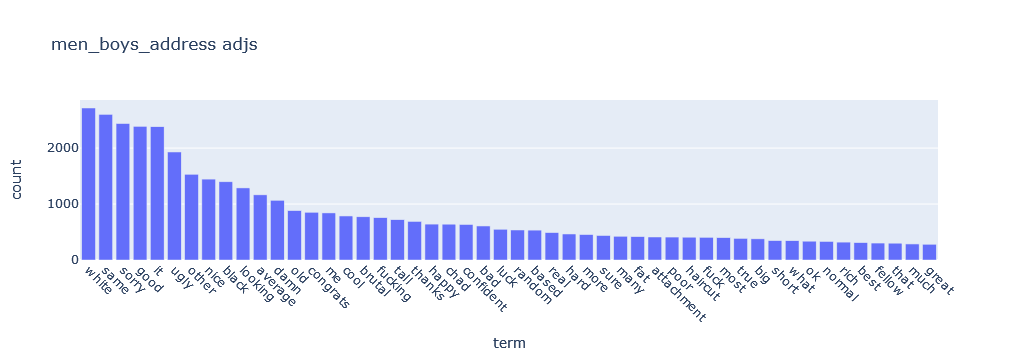

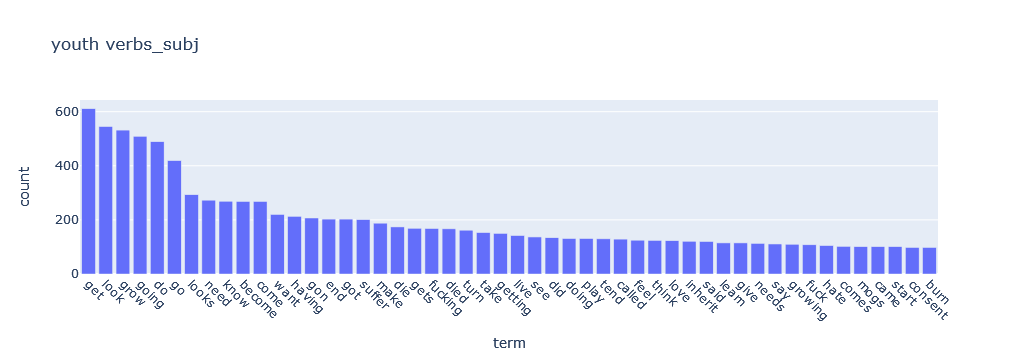

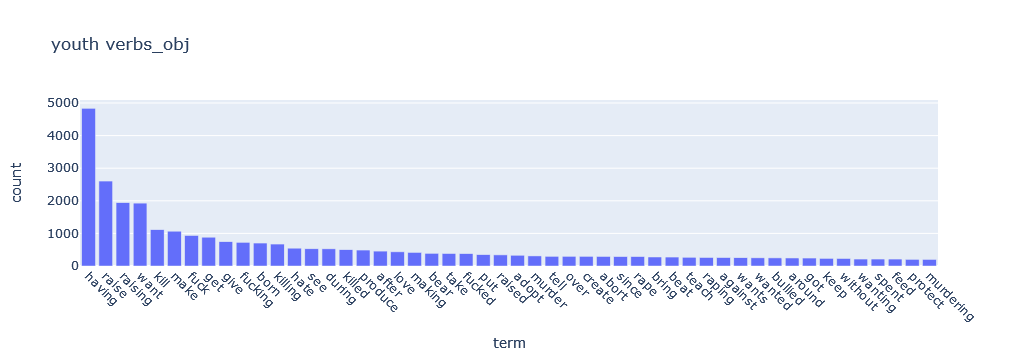

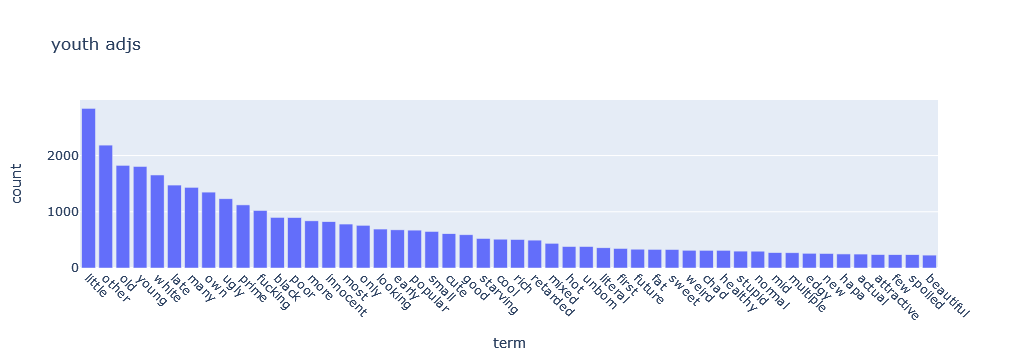

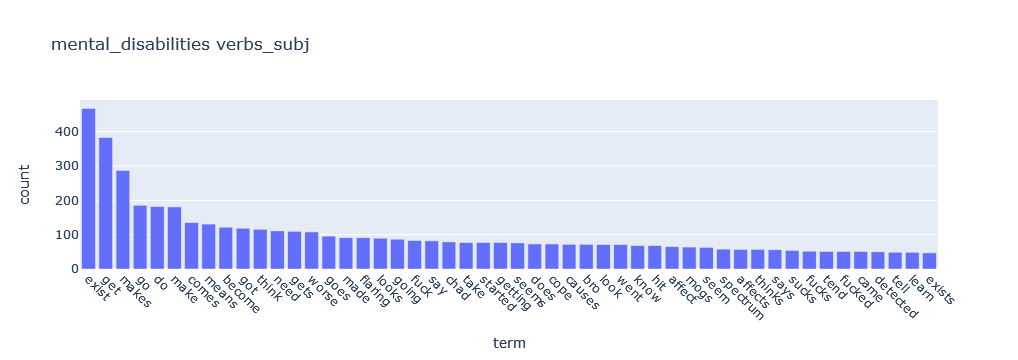

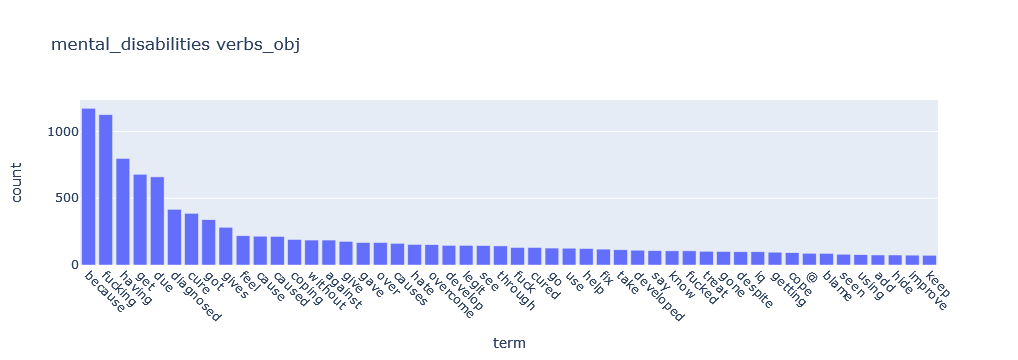

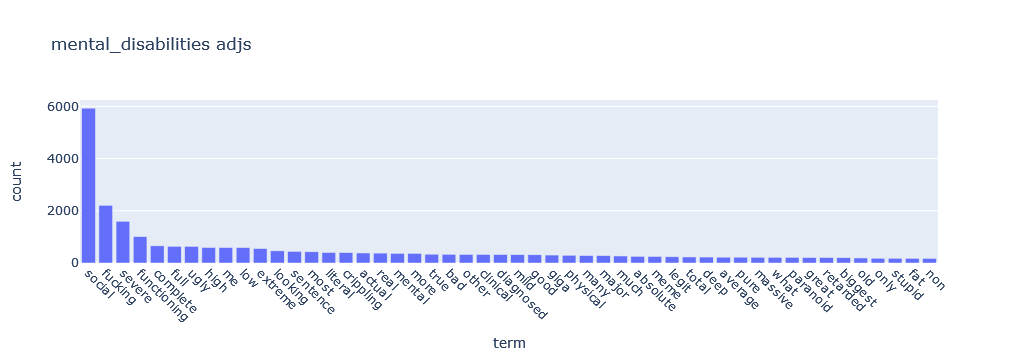

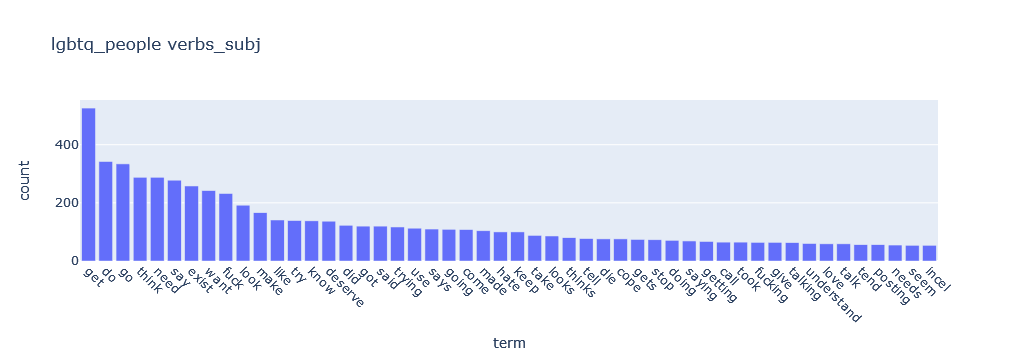

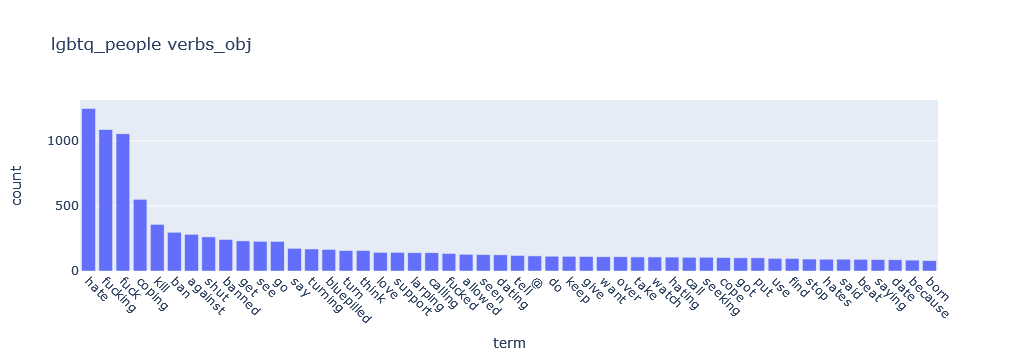

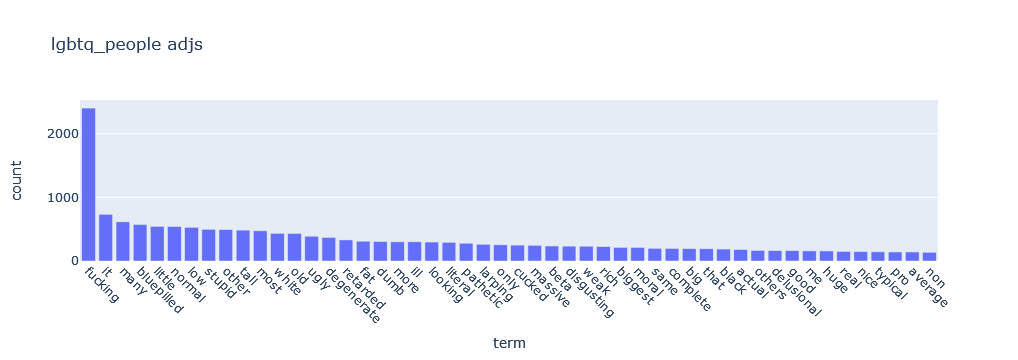

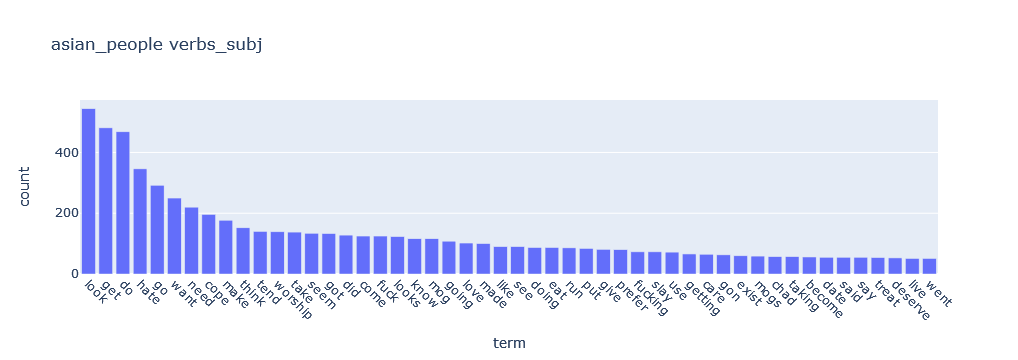

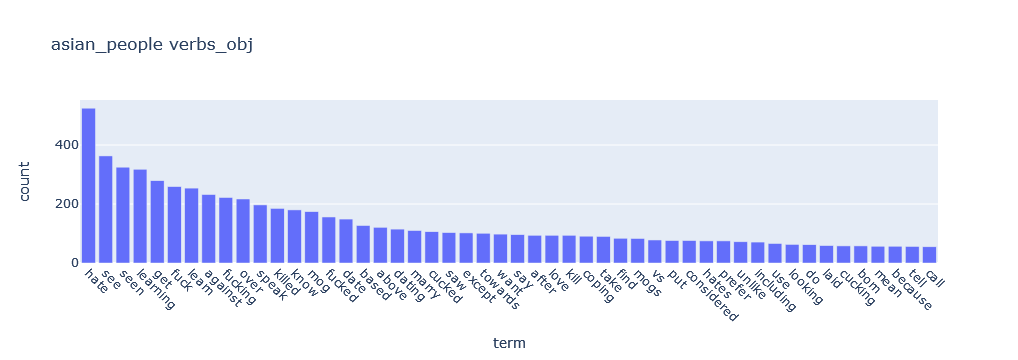

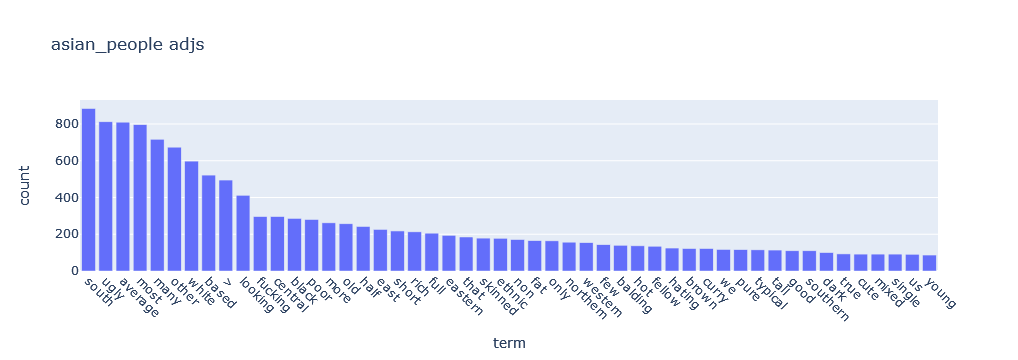

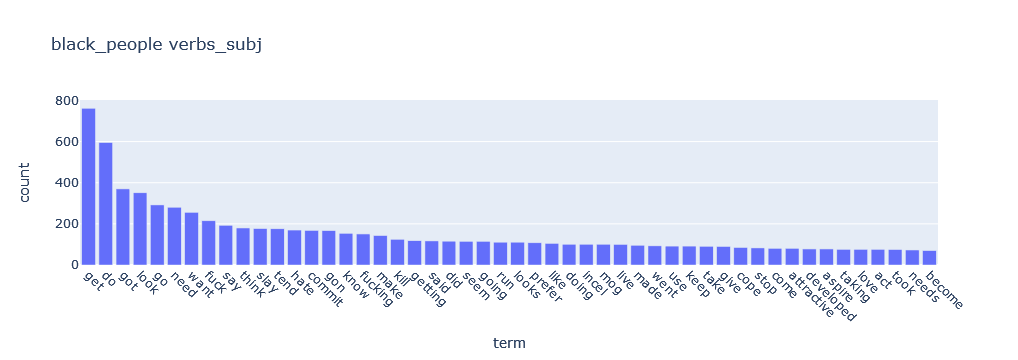

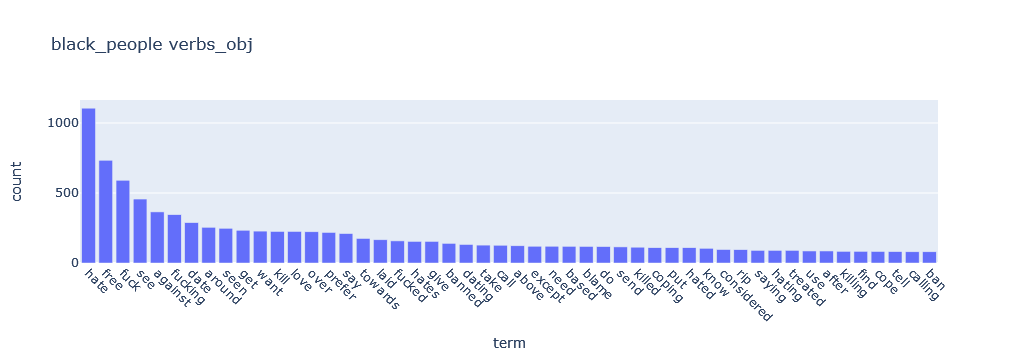

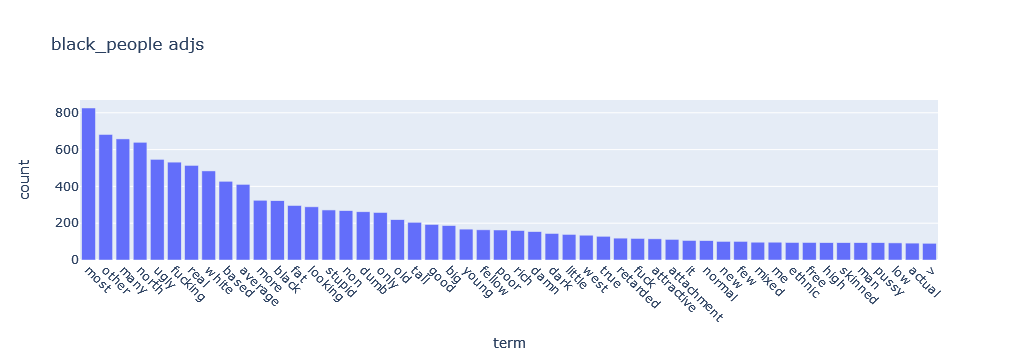

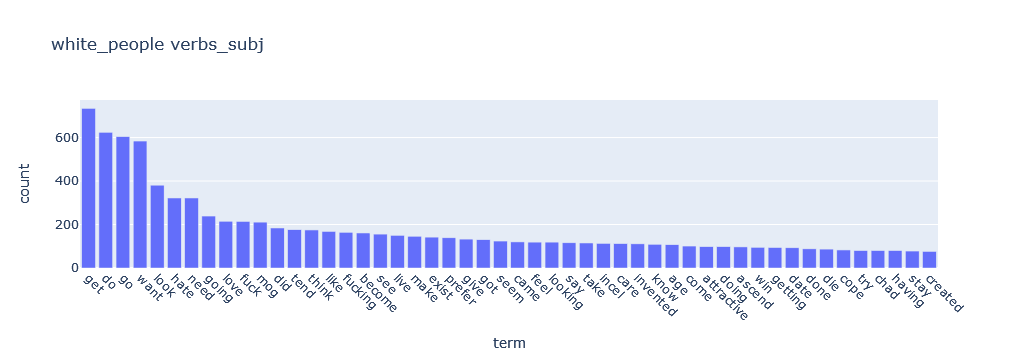

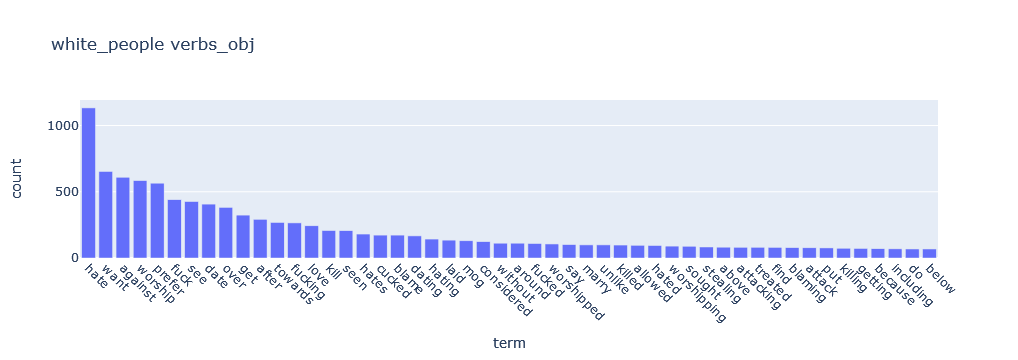

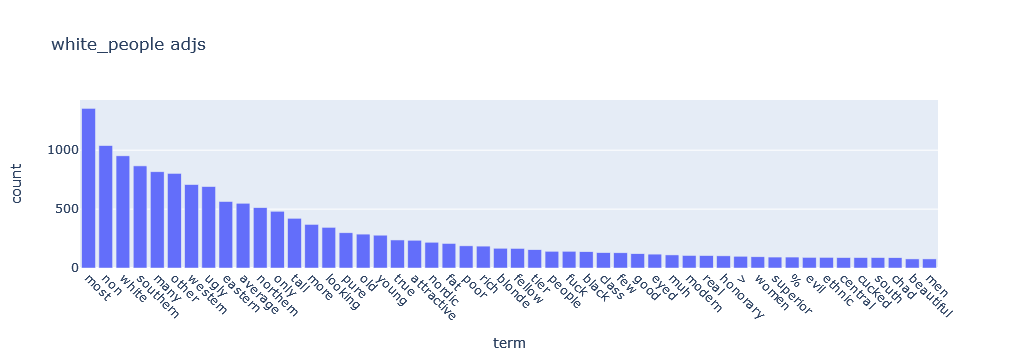

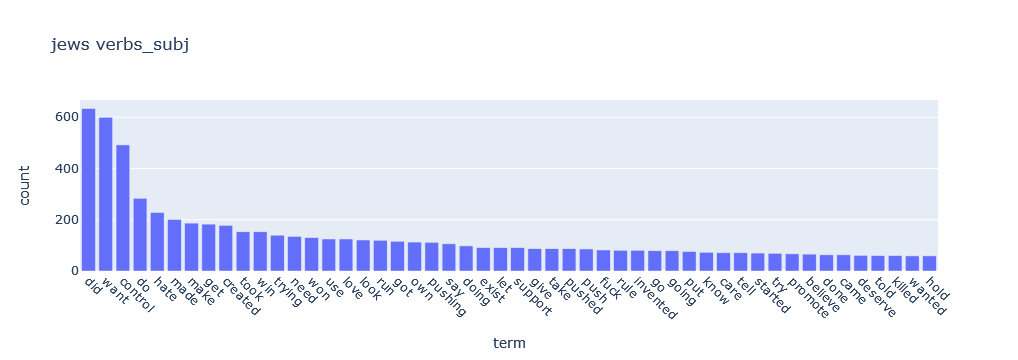

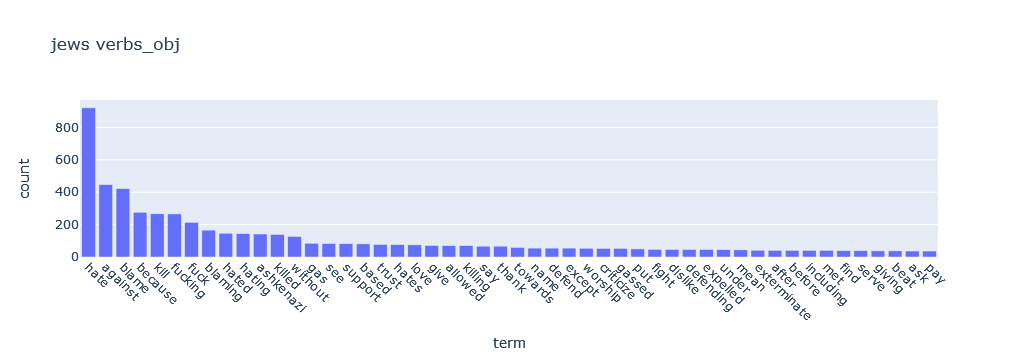

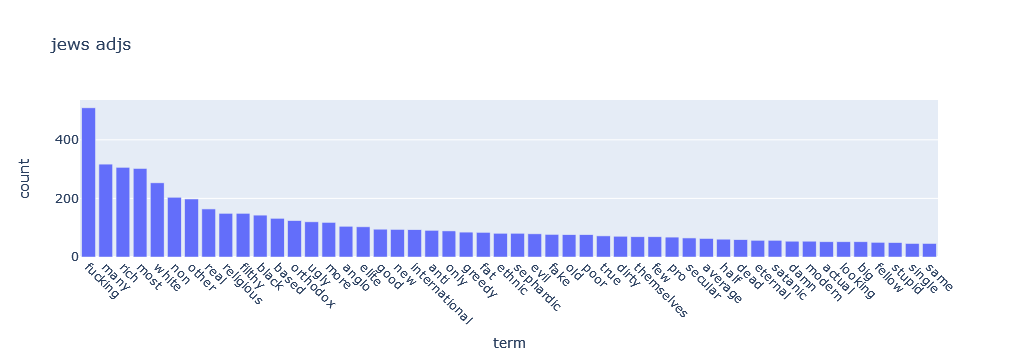

In [6]:
import plotly.express as px

for gp in agg.index[:12]:
    for col in ['verbs_subj', 'verbs_obj', 'adjs']:
        terms, counts = zip(*agg.loc[gp, col][:50])
        fig = px.bar(x=terms, y=counts, title=f'{gp} {col}', labels=dict(x="term", y="count"))
        fig.update_xaxes(tickangle=45)
        # fig.show(config = {'staticPlot': True})
        fig.show()

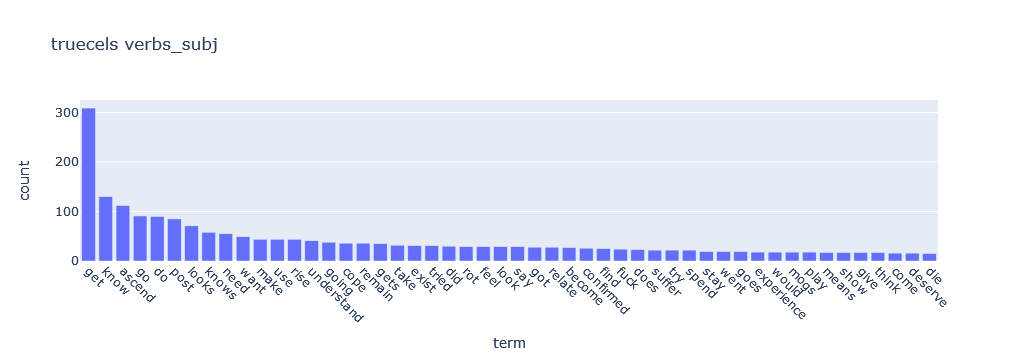

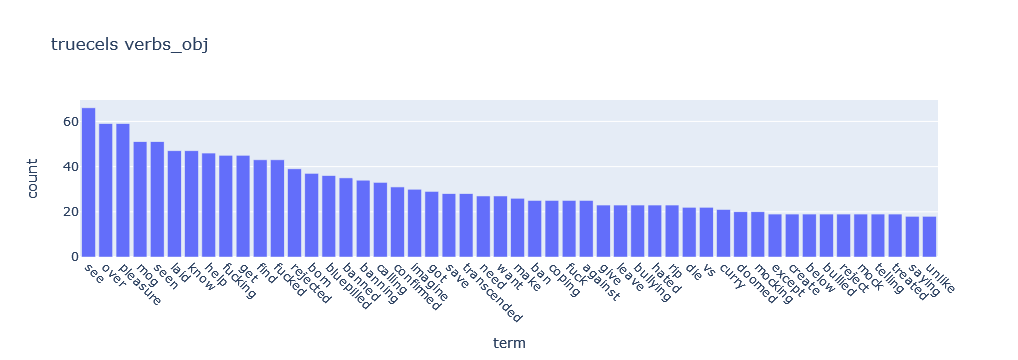

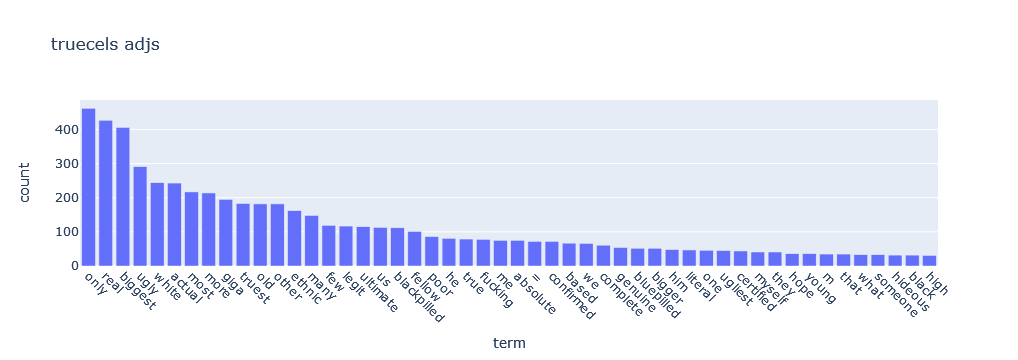

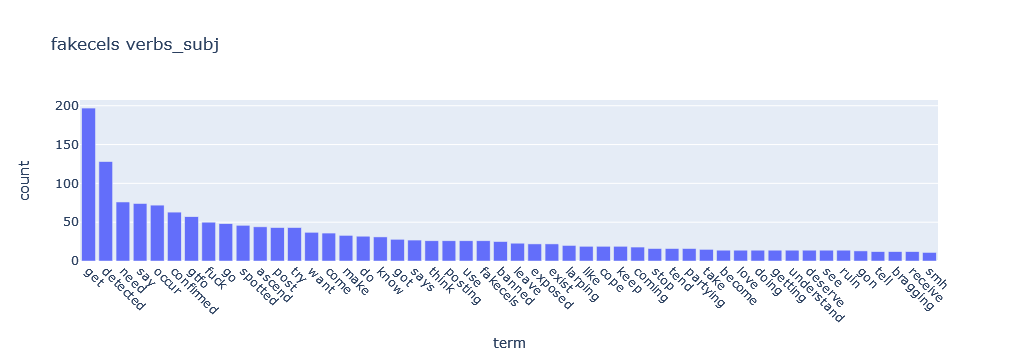

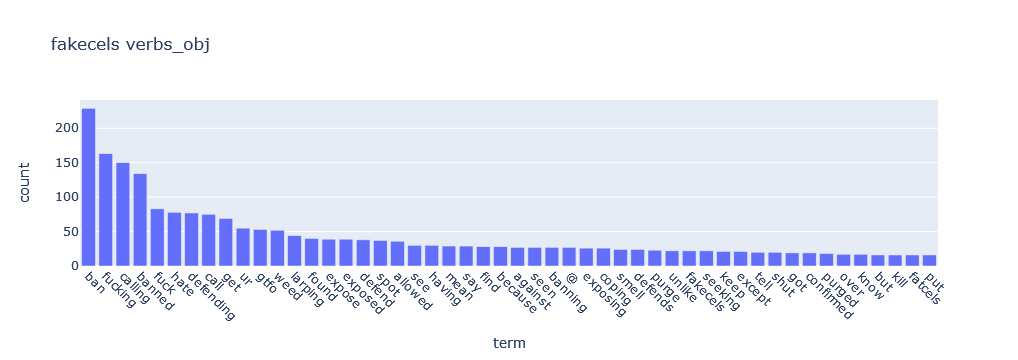

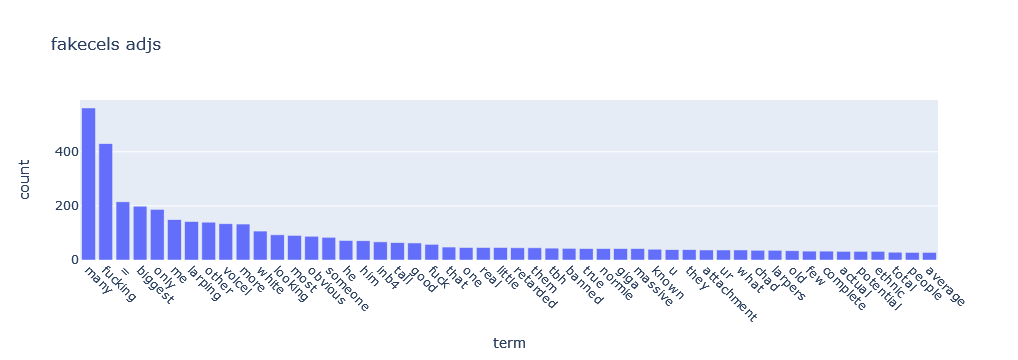

In [7]:
import plotly.express as px

for gp in ['truecels', 'fakecels']:
    for col in ['verbs_subj', 'verbs_obj', 'adjs']:
        terms, counts = zip(*agg.loc[gp, col][:50])
        fig = px.bar(x=terms, y=counts, title=f'{gp} {col}', labels=dict(x="term", y="count"))
        fig.update_xaxes(tickangle=45)
        # fig.show(config = {'staticPlot': True})
        fig.show()

## Look into examples use of actions, attributes

In [14]:
gp = 'truecels'
term = 'ethnic'
field = 'adjs'
# field = 'verbs_subj'
# field = 'verbs_obj'

pd.set_option('display.max_colwidth', None)
crit = (exploded.identity_group == gp) & (exploded.actions_attributes.map(lambda x: term in x[field] if isinstance(x, dict) else False))
exploded.loc[crit, ['identity_group', 'content', 'actions_attributes']].sample(10)

,identity_group,content,actions_attributes
763032,truecels,brag post . you 're just a richfag who wants to show off . i 'd rather be a poor normie - tier mayo than a middle - class ethnic truecel .,"{'verbs_subj': [], 'verbs_obj': [], 'adjs': ['class', 'ethnic']}"
4986598,truecels,"my social circle consists of me , my friend who is a manlet , another friend who is an ethnic truecel and only one somewhat normalfag . i decided to go to this social gathering with my best friend , who is the manlet . this social gathering took place at our old middle school so we decided to go just to visit and see how much the school has changed overtime while we were gone . there was some food to eat and some games to entertain the little kids . mogs me","{'verbs_subj': [], 'verbs_obj': [], 'adjs': ['ethnic']}"
789841,truecels,he is just a troll . i 'm an ethnic trucel .,"{'verbs_subj': [], 'verbs_obj': [], 'adjs': ['ethnic']}"
303698,truecels,"shin no as we know from a previous thread , that has made a thread on looksmax.me of his imminent suicide . it was a disheartening response to hear and to know that a prominent figure of this forum is going to an hero . however , it has come to light that did n't successfully kill himself . view attachment 354336 instead he 's looking towards getting someone else to do the bidding or himself . but who was it or what caused our to commit such an act ? well here are the list of users from looksmax.me ( as said by colvin himself ) that were personally responsible for the attempt of suicide by colvin . looksmax bullies / trolls / slanderers : gorilla ( fuck you you're by far the worst one on this list ) rightfulcel looksmaxxer234 biggdink improover copemaxxing johncruz12345 fras these heinous individuals will be written on colvin 's future suicide note and the fbi will be at their doors for bullying a khhv ugly ethnic truecel . and here are the threads associated : gorilla is a bully , liar , and baiting troll | looksmax.me - men 's self - improvement & aesthetics looksmax.me colvin is a tyrone | looksmax.me - men 's self - improvement & aesthetics is an experiment made by the kkk to destroy the bbcpill he s a gigachad with nw1 who claims to be a aspie virgin . colvin reveal yourself we know you re larping . you mog salludon looksmax.me dumbass dude is black like me , he can just die by cop .","{'verbs_subj': [], 'verbs_obj': ['bullying'], 'adjs': ['khhv', 'ugly', 'ethnic']}"
3812137,truecels,"there 's no good reason for a middle - class urbanite ethnic trucel like me to get on the same clown car as the uncouth , conspiracy - mongering poorfag cumskin normies that make up much of trump 's base . why should i get behind whackjobs along the lines of marjorie taylor greene and alex jones ? there 's every reason for me to support business as usual in washington . joe biden , unlike his predecessor , is a reasonable , predictable centrist who respects institutional norms and the boundaries of his office , and always has . indeed , the fact that the typical maga ape ( as exemplified by this faggot ) is so intolerant of opposing views showcases the reason why the lunatics have taken over the republican party . they 've completely shut out dissent . lifelong moderate conservatives in the mold of the wsj 's editorial board who refuse to indulge in the same delusions and conspiracies as far - right populists do are silenced or risk being labeled as rinos . my politics are closer to that of the wall street journal 's editorial board than to the average cucktears member , but the trump chimps on this forum are so far to the right that anyone to the left of strom thurmond might as well be a marxist . there 's no talking sense to trump supporters . ahh tl : dr cuck .","{'verbs_subj': [], 'verbs_obj': [], 'adjs': ['class', 'urbanite', 'ethnic']}"
789846,truecels,i 'm an ethnic trucel . fuck you faggot . you and many others here do nt know the meaning of the word truecel . all these fucking 6 ft tall guys calling themselves 